In [1]:
import torch
from torch.optim import Adam

import numpy as np
from matplotlib import pyplot as plt
import PIL.Image as Image

from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

from torchvision import transforms
from torchvision import datasets
import time

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [3]:
directory = 'unlrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))


Number of images 14245


In [4]:
class UNLRG(data.Dataset):
    def __init__(self, images, transform=None, sz=64):
        self.data = images
        self.data_len = len(self.data)
        self.sz = sz
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
                transforms.CenterCrop(80),
                transforms.Resize(self.sz),
                transforms.ToTensor()])
        else : self.transform = transform

#     def __load_data
            
    def __getitem__(self, index):
        index = index % self.data_len
        np_arr = self.data[index, :]
        ## reshape np_arr to 28x28
        np_arr = np_arr.reshape(128, 128)

        ## convert to PIL-image
        img = Image.fromarray((np_arr*255).astype('uint8'))

        #apply the transformations and return tensors
        return self.transform(img)
    def __len__(self):
        return self.data_len * 10
    def __repr__(self) -> str:
        return 'unLRG dataset'

In [5]:
images = np.array(images)
dataset = UNLRG(images)

In [6]:
np.max(images)

0.9996233380807099

In [28]:
class VAE(nn.Module):
    def __init__(self, lt_dim=10):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [29]:
data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False)
sample = iter(data_loader).next()
sample.shape

torch.Size([64, 1, 64, 64])

In [130]:
device = 'cuda'

vae = VAE().to(device)
optimizer = Adam(vae.parameters(), lr=0.001)
epochs = 100

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

class Beta_vae_loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        #self.recon_ls = nn.BCEWithLogitsLoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
#         print(res.shape)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

beta_vae_loss = Beta_vae_loss(gamma=8, max_capacity=10, epochs=epochs)

In [131]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:10.4f}\tR_Loss: {:10.4f}\tCapacity: {:10.4f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [132]:
for epoch in range(1, epochs+1):
    start = time.time()
    s = train_step(vae, 'cuda' ,data_loader, optimizer, epoch)
    beta_vae_loss.update()
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))

Train Epoch: 1 [111250/142450 (100%)]	Loss:   119.7437	R_Loss:   109.3018	Capacity:     0.0000	Time 78.75s
Train Epoch: 2 [111250/142450 (100%)]	Loss:   111.2878	R_Loss:    98.6034	Capacity:     0.1000	Time 78.73s
Train Epoch: 3 [111250/142450 (100%)]	Loss:   109.5837	R_Loss:    99.8434	Capacity:     0.2000	Time 78.47s
Train Epoch: 4 [111250/142450 (100%)]	Loss:   105.7921	R_Loss:    95.9027	Capacity:     0.3000	Time 78.64s
Train Epoch: 5 [111250/142450 (100%)]	Loss:   108.6595	R_Loss:    98.3672	Capacity:     0.4000	Time 78.39s
Train Epoch: 6 [111250/142450 (100%)]	Loss:   102.6580	R_Loss:    93.2776	Capacity:     0.5000	Time 78.71s
Train Epoch: 7 [111250/142450 (100%)]	Loss:   101.2362	R_Loss:    92.3374	Capacity:     0.6000	Time 78.32s
Train Epoch: 8 [111250/142450 (100%)]	Loss:   102.5077	R_Loss:    93.7782	Capacity:     0.7000	Time 78.42s
Train Epoch: 9 [111250/142450 (100%)]	Loss:   103.7585	R_Loss:    94.7742	Capacity:     0.8000	Time 78.44s
Train Epoch: 10 [111250/142450 (100%)

Train Epoch: 77 [111250/142450 (100%)]	Loss:    77.0939	R_Loss:    69.0788	Capacity:     7.6000	Time 77.77s
Train Epoch: 78 [111250/142450 (100%)]	Loss:    76.0947	R_Loss:    69.2871	Capacity:     7.7000	Time 77.73s
Train Epoch: 79 [111250/142450 (100%)]	Loss:    77.4180	R_Loss:    69.1138	Capacity:     7.8000	Time 77.85s
Train Epoch: 80 [111250/142450 (100%)]	Loss:    75.5484	R_Loss:    68.2387	Capacity:     7.9000	Time 78.03s
Train Epoch: 81 [111250/142450 (100%)]	Loss:    78.4123	R_Loss:    69.9603	Capacity:     8.0000	Time 77.67s
Train Epoch: 82 [111250/142450 (100%)]	Loss:    75.8923	R_Loss:    69.1955	Capacity:     8.1000	Time 77.86s
Train Epoch: 83 [111250/142450 (100%)]	Loss:    75.4684	R_Loss:    68.9061	Capacity:     8.2000	Time 77.72s
Train Epoch: 84 [111250/142450 (100%)]	Loss:    74.0502	R_Loss:    68.3150	Capacity:     8.3000	Time 77.94s
Train Epoch: 85 [111250/142450 (100%)]	Loss:    76.0260	R_Loss:    69.9759	Capacity:     8.4000	Time 78.10s
Train Epoch: 86 [111250/1424

In [133]:
# sample = iter(data_loader).next()

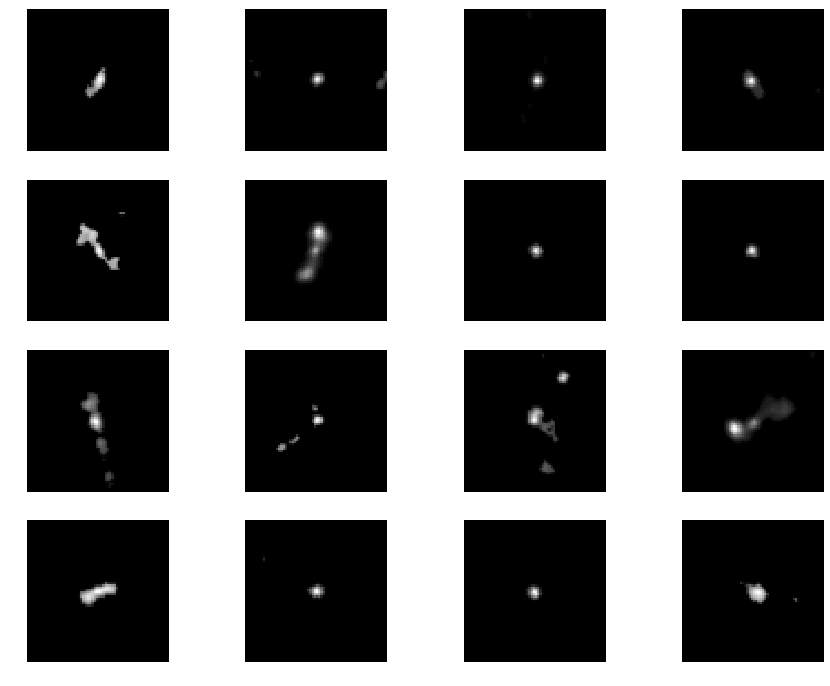

In [134]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(sample[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

In [135]:
with torch.no_grad():
    recon = vae(sample.to(device))[0].cpu()

In [136]:
recon.shape

torch.Size([64, 1, 64, 64])

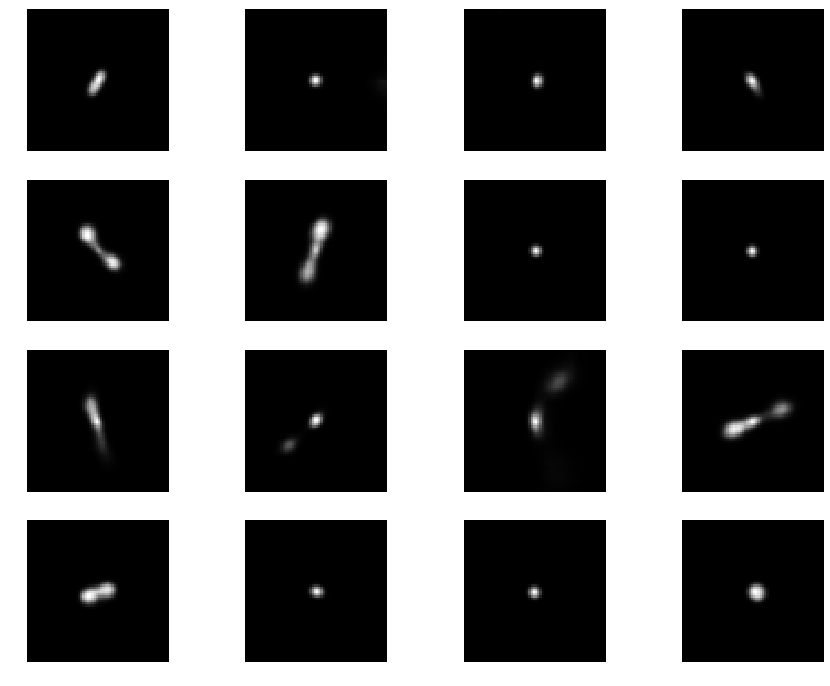

In [137]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(recon[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

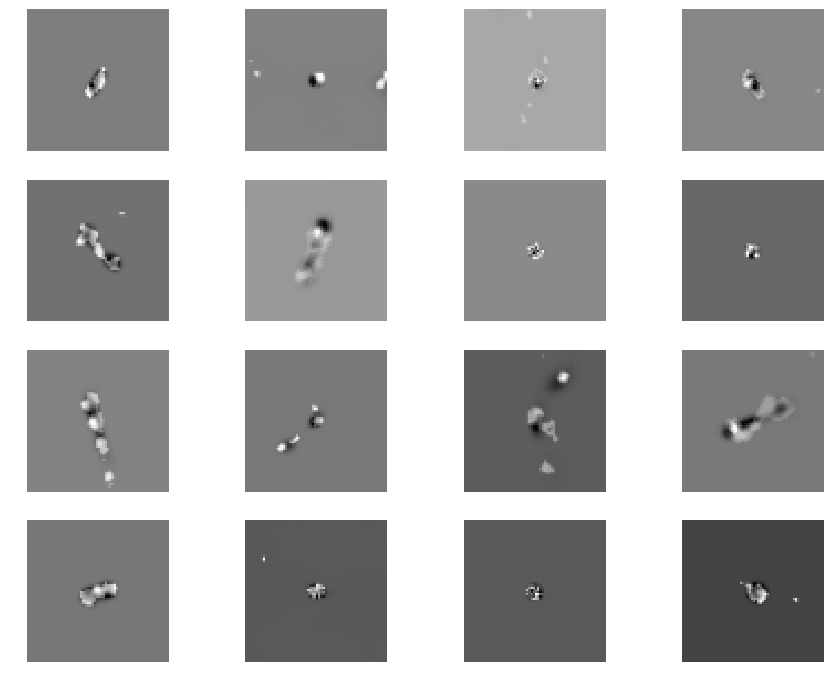

In [138]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        o, r = sample[i*4 + j][0], recon[i*4 + j][0] 
        ax[i][j].imshow(o - r, cmap='gray')
        ax[i][j].axis('off')

In [139]:
torch.save(vae, 'vae_model')
# cae = torch.load('cae_model')
# cae.eval()

In [140]:
s = sample[4:5]

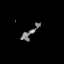

In [141]:
im = Image.fromarray((sample[4:5].numpy()[0][0]*255).astype('uint8'))
im = im.rotate(90)
t = transforms.ToTensor()(im).view(1, 1 ,64, 64)
im

tensor(-0.2540, device='cuda:0')

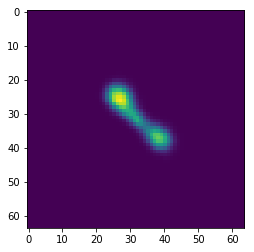

In [142]:
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
#     e[0][0] = -2
    d = vae.decode(e)
plt.imshow(d.cpu()[0][0])
e[0][0]

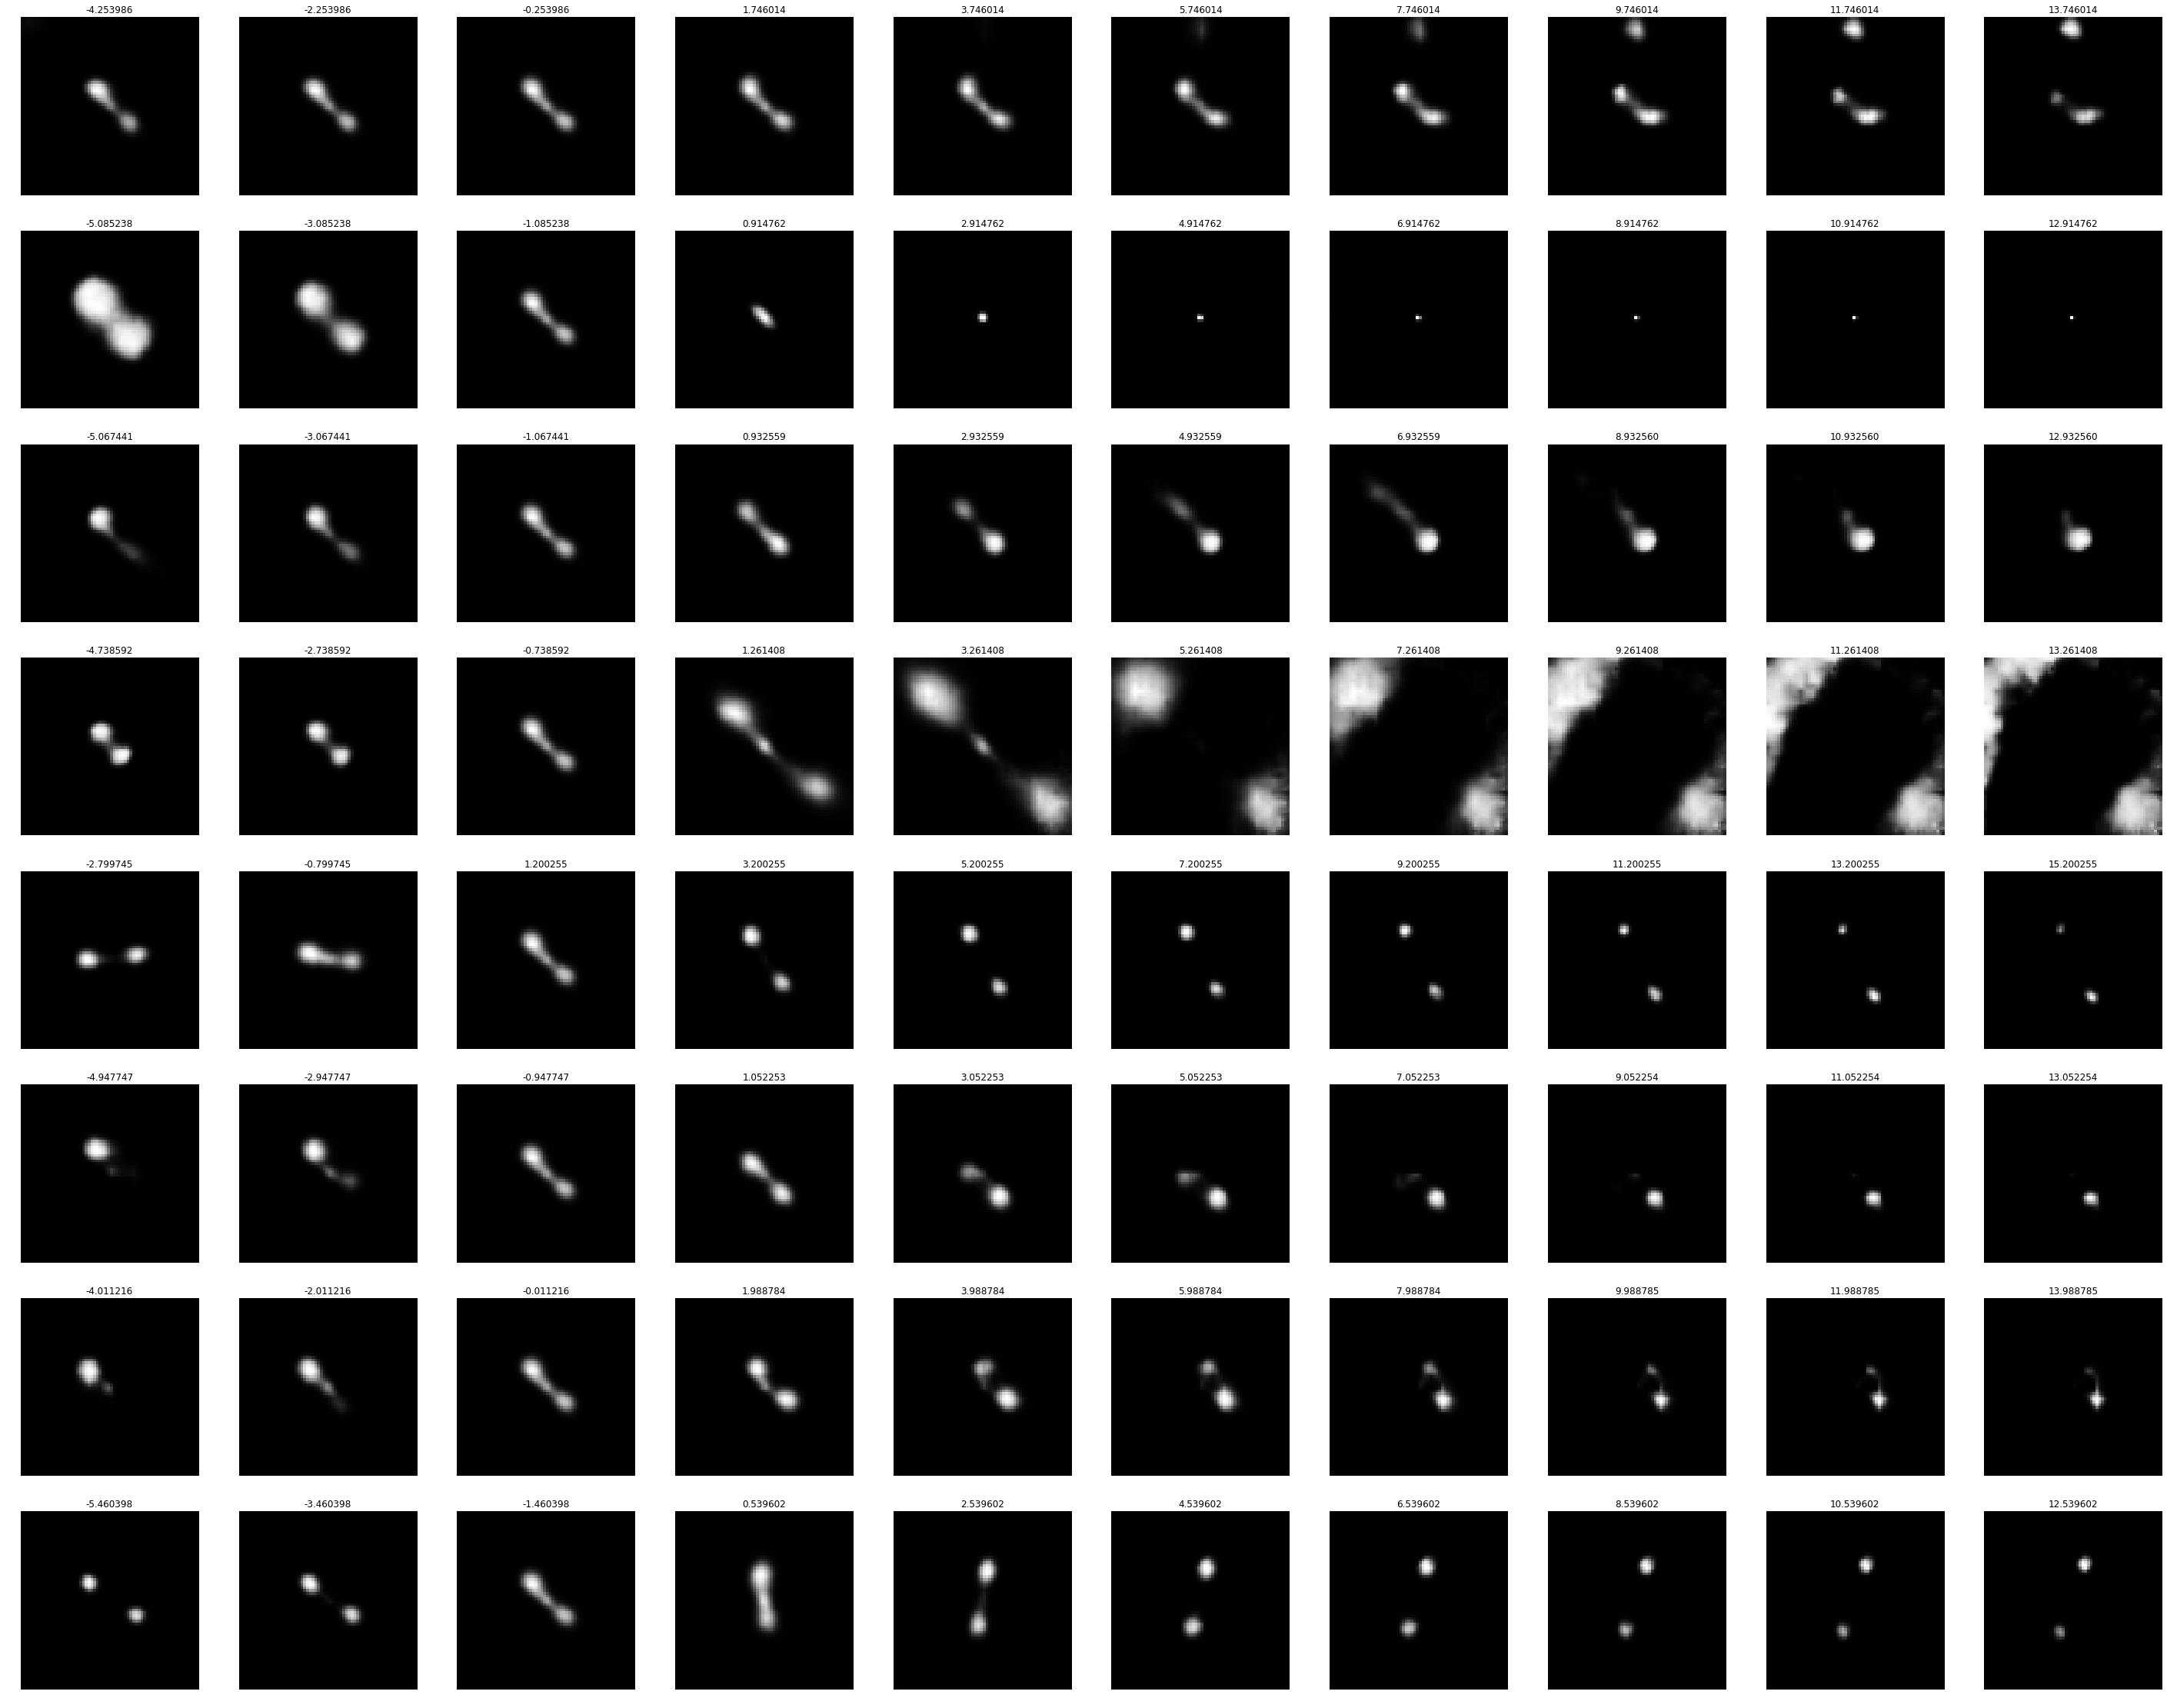

In [143]:
nimg = 10 * 8
r = 10
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4 + v + 2*j
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [91]:
with torch.no_grad():
    e_s = vae.encode(s.to(device))[0]
    t_s = vae.encode(t.to(device))[0]

In [97]:
d_s = e_s.mul(-1)

In [98]:
e_s.cpu()

tensor([[-0.5078, -0.4628, -0.4035,  0.4988, -1.5615, -0.6340,  1.6270,  0.5085]])

In [99]:
t_s.cpu()

tensor([[ 0.3659,  0.4764,  0.6780, -0.1843, -1.7471, -0.6219, -1.6232,  0.6449]])

In [123]:
with torch.no_grad():
    dd_s = vae.decode(d_s)
    ee_s = vae.decode(e_s)
    tt_s = vae.decode(t_s)

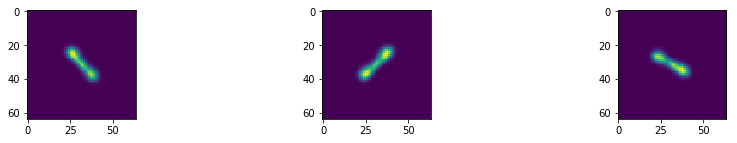

In [124]:
f, ax = plt.subplots(1, 3, figsize=(3 * 5,  2))
ax[0].imshow(ee_s.cpu().numpy()[0,0])
ax[1].imshow(tt_s.cpu().numpy()[0,0])
ax[2].imshow(dd_s.cpu().numpy()[0,0])
plt.show()

In [121]:
d_s[0][-2] *= -1

In [122]:
d_s

tensor([[ 0.5078,  0.4628,  0.4035, -0.4988, -1.5615, -0.6340,  1.6270,  0.5085]],
       device='cuda:0')